In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import json
from pathlib import Path

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils.misc import get_atoms_batch

from time import perf_counter

Initialize test slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3(001)"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Load prepared pristine slab
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": json.load(open(offset_data_path, "r")),
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 7.871,  7.941, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([ 7.871,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829])]...


Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [5]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}"
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

/home/dux/NeuralForceField/models
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [6]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    ads_positions,  # TODO: move ads_positions to be created within SurfaceSystem
    calc=nff_surf_calc,
    system_settings=system_settings,
    default_io_path=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

2024-06-28 15:23:36,446|INFO|initializing 64 virtual atoms
2024-06-28 15:23:36,451|INFO|Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-06-28 15:23:36,452|INFO|Number of pristine atoms is 60
2024-06-28 15:23:36,462|INFO|bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
2024-06-28 15:23:36,463|INFO|surface indices are [ 7  8 22 23 37 38 52 53]
2024-06-28 15:23:36,464|INFO|constraints are FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59])


      Step     Time          Energy         fmax
BFGS:    0 15:23:37     -467.521881        0.2044
BFGS:    1 15:23:37     -467.525757        0.1803
BFGS:    2 15:23:37     -467.540619        0.0793
BFGS:    3 15:23:37     -467.540924        0.0598
BFGS:    4 15:23:37     -467.541351        0.0059


Test calculate pristine surface

In [7]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-06-28 15:23:37,596|INFO|Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
2024-06-28 15:23:37,597|INFO|There are 60 atoms in pristine slab


      Step     Time          Energy         fmax
BFGS:    0 15:23:37     -467.521881        0.2044
BFGS:    1 15:23:37     -467.525757        0.1803
BFGS:    2 15:23:37     -467.540619        0.0793
BFGS:    3 15:23:37     -467.540924        0.0598
BFGS:    4 15:23:38     -467.541351        0.0059


2024-06-28 15:23:38,150|INFO|Initial energy is 12.471
2024-06-28 15:23:38,151|INFO|Using user specified run folder SrTiO3(001)
2024-06-28 15:23:38,152|INFO|Starting with iteration 0
2024-06-28 15:23:38,152|INFO|Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
2024-06-28 15:23:38,153|INFO|In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:23:38     -470.517181        3.1590
BFGS:    1 15:23:38     -470.779022        2.8433
BFGS:    2 15:23:38     -471.382172        0.8748
BFGS:    3 15:23:38     -471.420502        0.7076
BFGS:    4 15:23:38     -471.448761        0.4202
BFGS:    5 15:23:38     -471.466919        0.3634
BFGS:    6 15:23:38     -471.472260        0.3204
BFGS:    7 15:23:38     -471.487885        0.3138
BFGS:    8 15:23:39     -471.500000        0.3268
BFGS:    9 15:23:39     -471.512177        0.3008
BFGS:   10 15:23:39     -471.519073        0.2953
BFGS:   11 15:23:39     -471.532013        0.2727
BFGS:   12 15:23:39     -471.539795        0.2840
BFGS:   13 15:23:39     -471.546967        0.2678
BFGS:   14 15:23:39     -471.554535        0.1943
BFGS:   15 15:23:39     -471.559235        0.2422
BFGS:   16 15:23:39     -471.563965        0.2636
BFGS:   17 15:23:39     -471.567963        0.1795
BFGS:   18 15:23:39     -471.570099        0.1894
B

2024-06-28 15:23:48,488|INFO|optim structure has Energy = 12.471
2024-06-28 15:23:48,496|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:23:48     -469.891357        1.9079
BFGS:    1 15:23:48     -469.968719        1.3758
BFGS:    2 15:23:48     -470.109497        0.8532
BFGS:    3 15:23:49     -470.139923        0.8533
BFGS:    4 15:23:49     -470.214691        0.6635
BFGS:    5 15:23:49     -470.229340        0.3352
BFGS:    6 15:23:49     -470.235229        0.2399
BFGS:    7 15:23:49     -470.245697        0.1509
BFGS:    8 15:23:49     -470.246979        0.1491
BFGS:    9 15:23:49     -470.251465        0.1021
BFGS:   10 15:23:49     -470.252228        0.0936
BFGS:   11 15:23:49     -470.253540        0.0806
BFGS:   12 15:23:49     -470.253906        0.0779
BFGS:   13 15:23:49     -470.254486        0.0735
BFGS:   14 15:23:50     -470.255096        0.0841
BFGS:   15 15:23:50     -470.256195        0.1112
BFGS:   16 15:23:50     -470.257812        0.1247
BFGS:   17 15:23:50     -470.261200        0.2152
BFGS:   18 15:23:50     -470.271271        0.4922
B

2024-06-28 15:23:59,481|INFO|optim structure has Energy = 12.588
2024-06-28 15:23:59,489|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:23:59     -438.808929       64.0735
BFGS:    1 15:23:59     -453.197479       38.3339
BFGS:    2 15:23:59     -368.388672     1471.4737
BFGS:    3 15:23:59     -458.831909      116.0686
BFGS:    4 15:24:00     -458.510406       62.8682
BFGS:    5 15:24:00     -463.698486        5.9062
BFGS:    6 15:24:00     -464.520752        4.7092
BFGS:    7 15:24:00     -465.620941        7.3762
BFGS:    8 15:24:00     -466.253998        6.2425
BFGS:    9 15:24:00     -466.571289        4.6175
BFGS:   10 15:24:00     -466.876312        2.9740
BFGS:   11 15:24:00     -467.379517        3.1569
BFGS:   12 15:24:00     -467.875885        3.7829
BFGS:   13 15:24:00     -468.265503        2.2662
BFGS:   14 15:24:00     -468.496094        9.5464
BFGS:   15 15:24:01     -468.760345        8.6079
BFGS:   16 15:24:01     -468.993774        7.2006
BFGS:   17 15:24:01     -469.170441       16.7440
BFGS:   18 15:24:01     -469.430878        1.8877
B

2024-06-28 15:24:10,030|INFO|optim structure has Energy = 8.872
2024-06-28 15:24:10,038|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:24:10     -416.693207       77.1024
BFGS:    1 15:24:10     -442.204010       33.5623
BFGS:    2 15:24:10     -452.283203       28.6360
BFGS:    3 15:24:10     -460.470825       21.5792
BFGS:    4 15:24:10     -466.912567       13.0215
BFGS:    5 15:24:10     -471.199677        7.5437
BFGS:    6 15:24:10     -473.988678        5.2588
BFGS:    7 15:24:10     -476.126221        4.5136
BFGS:    8 15:24:10     -477.825287        3.5447
BFGS:    9 15:24:10     -479.145905        3.5405
BFGS:   10 15:24:11     -480.314850        4.6830
BFGS:   11 15:24:11     -481.475372        5.7085
BFGS:   12 15:24:11     -482.432373        6.2895
BFGS:   13 15:24:11     -483.229004        4.3283
BFGS:   14 15:24:11     -484.100342        3.6689
BFGS:   15 15:24:11     -484.953827        2.4377
BFGS:   16 15:24:11     -485.507538        2.5242
BFGS:   17 15:24:11     -486.126068        2.6999
BFGS:   18 15:24:11     -486.604584        2.8285
B

2024-06-28 15:24:19,897|INFO|optim structure has Energy = 8.872
2024-06-28 15:24:19,903|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:24:20     -425.146729       63.7818
BFGS:    1 15:24:20     -447.332672       30.6889
BFGS:    2 15:24:20     -458.923462       27.8488
BFGS:    3 15:24:20     -466.876923       12.8454
BFGS:    4 15:24:20     -471.597809        7.5552
BFGS:    5 15:24:20     -474.147491        4.2349
BFGS:    6 15:24:20     -475.628998        3.7957
BFGS:    7 15:24:20     -476.618134        3.2264
BFGS:    8 15:24:20     -477.394928        3.3012
BFGS:    9 15:24:20     -478.440460        3.6393
BFGS:   10 15:24:20     -479.198486        3.1538
BFGS:   11 15:24:21     -479.645721        2.1593
BFGS:   12 15:24:21     -480.079590        3.0666
BFGS:   13 15:24:21     -480.571442        3.9918
BFGS:   14 15:24:21     -481.064209        4.3634
BFGS:   15 15:24:21     -481.555542        3.7037
BFGS:   16 15:24:21     -482.063599        1.9399
BFGS:   17 15:24:21     -482.337036        1.4877
BFGS:   18 15:24:21     -482.657959        1.1031
B

2024-06-28 15:24:30,028|INFO|optim structure has Energy = 3.488
2024-06-28 15:24:30,033|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:24:30     -422.733795       62.5376
BFGS:    1 15:24:30     -397.525299      795.3902
BFGS:    2 15:24:30     -438.769745      258.4841
BFGS:    3 15:24:30     -449.203461       68.4745
BFGS:    4 15:24:30     -122.808800     5587.2752
BFGS:    5 15:24:30     -455.326172       40.5166
BFGS:    6 15:24:30     -456.907959       31.2222
BFGS:    7 15:24:30     -458.974335       30.8494
BFGS:    8 15:24:30     -459.763824       21.0644
BFGS:    9 15:24:30     -460.520844       31.4207
BFGS:   10 15:24:31     -461.070953       20.0137
BFGS:   11 15:24:31     -461.891205       15.6069
BFGS:   12 15:24:31     -462.250153        4.9280
BFGS:   13 15:24:31     -462.830353        9.7567
BFGS:   14 15:24:31     -463.292389       12.4282
BFGS:   15 15:24:31     -463.600098       13.4415
BFGS:   16 15:24:31     -463.879669       10.5542
BFGS:   17 15:24:31     -464.206543        4.3678
BFGS:   18 15:24:31     -464.527130        6.0953
B

2024-06-28 15:24:39,669|INFO|optim structure has Energy = 4.241
2024-06-28 15:24:39,674|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:24:39     -436.593018      125.0851
BFGS:    1 15:24:39     -457.932129       42.0899
BFGS:    2 15:24:39     -473.272461       35.2678
BFGS:    3 15:24:39     -483.010101       27.2880
BFGS:    4 15:24:40     -491.388031       13.6518
BFGS:    5 15:24:40     -495.971191        6.4504
BFGS:    6 15:24:40     -498.654877        4.9379
BFGS:    7 15:24:40     -500.648346        4.1880
BFGS:    8 15:24:40     -502.178070        3.7741
BFGS:    9 15:24:40     -503.374359        3.3284
BFGS:   10 15:24:40     -504.201996        4.1348
BFGS:   11 15:24:40     -505.201569        4.9708
BFGS:   12 15:24:40     -506.752838        4.4925
BFGS:   13 15:24:40     -507.845215        4.8284
BFGS:   14 15:24:40     -508.751831        4.2985
BFGS:   15 15:24:41     -509.551483        3.1362
BFGS:   16 15:24:41     -510.032806        1.8742
BFGS:   17 15:24:41     -510.416168        1.3607
BFGS:   18 15:24:41     -510.666229        1.5409
B

2024-06-28 15:24:49,269|INFO|optim structure has Energy = 4.241
2024-06-28 15:24:49,278|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:24:49     -429.890381       65.4625
BFGS:    1 15:24:49     -447.959930       73.8419
BFGS:    2 15:24:49     -448.718903      315.4094
BFGS:    3 15:24:49     -468.190765       43.2331
BFGS:    4 15:24:49     -474.035034       18.8444
BFGS:    5 15:24:49     -477.495209       10.0603
BFGS:    6 15:24:49     -479.707275       16.9607
BFGS:    7 15:24:49     -481.231659        7.8610
BFGS:    8 15:24:50     -482.297363       11.2289
BFGS:    9 15:24:50     -483.385345        5.0344
BFGS:   10 15:24:50     -484.273468        4.7918
BFGS:   11 15:24:50     -485.150665        4.9554
BFGS:   12 15:24:50     -486.126556        6.1572
BFGS:   13 15:24:50     -486.646820        4.1463
BFGS:   14 15:24:50     -487.372681        2.3209
BFGS:   15 15:24:50     -487.967682       14.6866
BFGS:   16 15:24:50     -488.140137       14.7591
BFGS:   17 15:24:50     -488.406036        3.4800
BFGS:   18 15:24:50     -488.517487       22.1031
B

2024-06-28 15:24:59,177|INFO|optim structure has Energy = 4.995
2024-06-28 15:24:59,185|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:24:59     -473.949432       40.6192
BFGS:    1 15:24:59     -482.911469       16.5062
BFGS:    2 15:24:59     -489.825043        9.9697
BFGS:    3 15:24:59     -493.956146        4.7424
BFGS:    4 15:24:59     -495.628876        2.9852
BFGS:    5 15:24:59     -496.890717        2.4285
BFGS:    6 15:25:00     -497.669525        3.5075
BFGS:    7 15:25:00     -498.835785        4.7489
BFGS:    8 15:25:00     -499.706940        3.1606
BFGS:    9 15:25:00     -500.381256        1.9948
BFGS:   10 15:25:00     -501.136108        1.6884
BFGS:   11 15:25:00     -501.317841        1.7048
BFGS:   12 15:25:00     -501.831543        1.4455
BFGS:   13 15:25:00     -501.992889        1.5024
BFGS:   14 15:25:00     -502.203857        1.2041
BFGS:   15 15:25:00     -502.445404        1.2678
BFGS:   16 15:25:01     -502.569489        1.4496
BFGS:   17 15:25:01     -502.734772        1.2431
BFGS:   18 15:25:01     -502.842041        0.6624
B

2024-06-28 15:25:10,044|INFO|optim structure has Energy = 4.995
2024-06-28 15:25:10,050|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 15:25:10     -450.074921       66.2005
BFGS:    1 15:25:10     -470.009521       31.9432
BFGS:    2 15:25:10     -480.897797       28.4418
BFGS:    3 15:25:10     -489.054718       15.2998
BFGS:    4 15:25:10     -494.557281        8.8737
BFGS:    5 15:25:10     -498.001678        4.9478
BFGS:    6 15:25:10     -500.477936        4.1898
BFGS:    7 15:25:10     -502.417725        4.1618
BFGS:    8 15:25:10     -503.899658        3.9243
BFGS:    9 15:25:11     -505.041901        3.7392
BFGS:   10 15:25:11     -505.917755        5.5995
BFGS:   11 15:25:11     -507.403168        4.5141
BFGS:   12 15:25:11     -509.123749        3.6702
BFGS:   13 15:25:11     -510.531219        4.0947
BFGS:   14 15:25:11     -511.583344        5.3253
BFGS:   15 15:25:11     -512.795105        5.1470
BFGS:   16 15:25:11     -514.005798        4.1777
BFGS:   17 15:25:11     -515.412659        2.4650
BFGS:   18 15:25:12     -515.967102        3.7983
B

2024-06-28 15:25:21,769|INFO|optim structure has Energy = 4.995


Time taken = 104.569 seconds


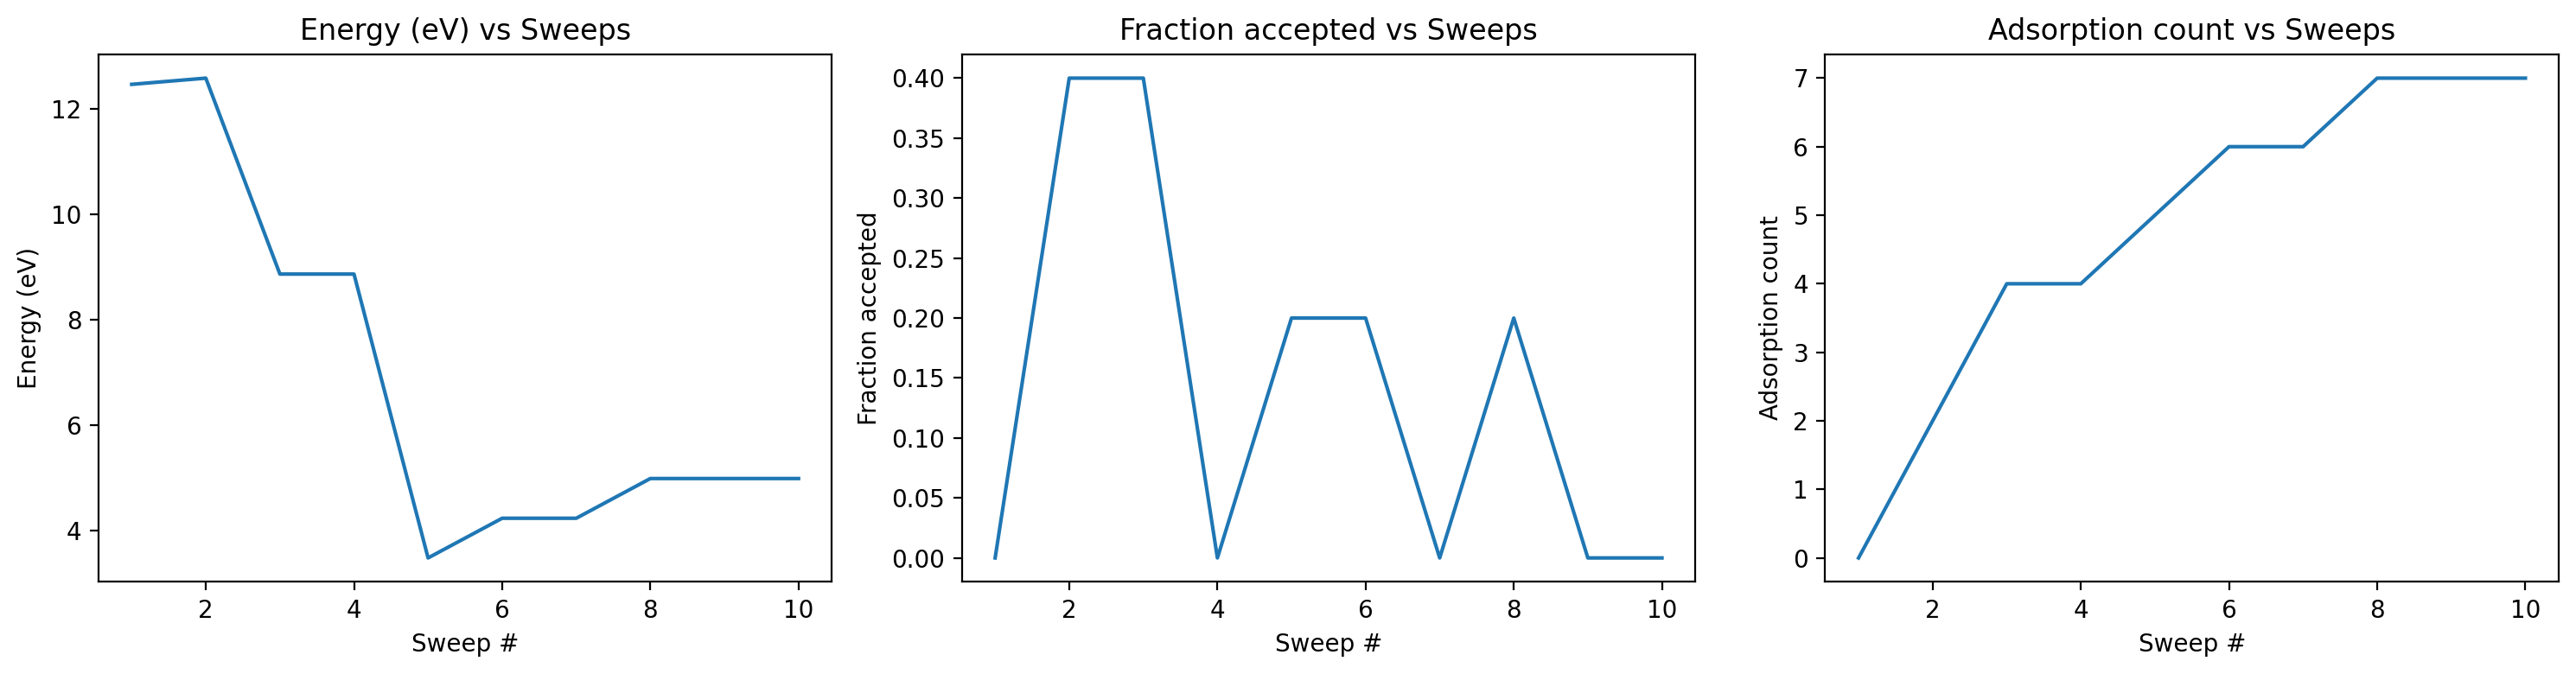

In [8]:
mcmc = MCMC(
    **sampling_settings,
    relax=calc_settings["relax_atoms"],
)

start = perf_counter()
mcmc.mcmc_run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

Save structures for later use in latent space clustering or analysis

In [9]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)